In [1]:
! conda install -c conda-forge folium --yes
! pip install emoji --upgrade
! pip install geocoder

Solving environment: done

## Package Plan ##

  environment location: /opt/conda/envs/Python36

  added / updated specs: 
    - folium


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    branca-0.3.1               |             py_0          25 KB  conda-forge
    vincent-0.4.4              |             py_1          28 KB  conda-forge
    openssl-1.1.1c             |       h516909a_0         2.1 MB  conda-forge
    folium-0.10.0              |             py_0          59 KB  conda-forge
    ca-certificates-2019.6.16  |       hecc5488_0         145 KB  conda-forge
    altair-3.2.0               |           py36_0         770 KB  conda-forge
    certifi-2019.6.16          |           py36_1         149 KB  conda-forge
    ------------------------------------------------------------
                                           Total:         3.3 MB

The following NEW packages will be INSTAL

In [2]:
# standard weapons of choice
import pandas as pd
from pandas.io.json import json_normalize
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import classification_report

# webscraping weapons of choice for standard HTMl sites
import requests
from bs4 import BeautifulSoup

# geolocation helper
import geocoder # module to convert an address into latitude and longitude values

# all the viz
import matplotlib.pyplot as plt
import folium
from tabulate import tabulate
import emoji

%matplotlib inline

##  <center>🍁 Toronto Neighborhood Exploration 🍁</center>

#### <center>Let's explore some neighborhoods in Toronto, Ontario Canada, cluster them together, and then find cool stuff in these neighborhoods by using the FourSquare API</center>
Let's get some data in here by scraping what we need from https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M

In [3]:
response = requests.get('https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M')
soup= BeautifulSoup(response.content, 'lxml')
toronto_table = soup.find_all('table')[0]
toronto_df = pd.read_html(str(toronto_table))[0]
toronto_df

,Postcode,Borough,Neighbourhood
0,M1A,Not assigned,Not assigned
1,M2A,Not assigned,Not assigned
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,Harbourfront
5,M5A,Downtown Toronto,Regent Park
6,M6A,North York,Lawrence Heights
7,M6A,North York,Lawrence Manor
8,M7A,Queen's Park,Not assigned
9,M8A,Not assigned,Not assigned


#### Lets get rid all the postcodes that don't have boroughs assciated wtih them. 📬

In [4]:
toronto_df = toronto_df[toronto_df['Borough'] != 'Not assigned']
toronto_df.head()

,Postcode,Borough,Neighbourhood
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,Harbourfront
5,M5A,Downtown Toronto,Regent Park
6,M6A,North York,Lawrence Heights


#### Let's collapse all of the neighborhoods into their corresponding boroughs and postcode so they appear on in a single row (neighborhoods belong to boroughs belong to postcodes)

In [5]:
toronto_df = toronto_df.groupby(['Postcode','Borough'], sort=False).agg(lambda x: ', '.join(x))
toronto_df.reset_index(level=['Postcode', 'Borough'], inplace=True)
toronto_df.head()

,Postcode,Borough,Neighbourhood
0,M3A,North York,Parkwoods
1,M4A,North York,Victoria Village
2,M5A,Downtown Toronto,"Harbourfront, Regent Park"
3,M6A,North York,"Lawrence Heights, Lawrence Manor"
4,M7A,Queen's Park,Not assigned


#### Some of the neighborhoods are not assigned.  If that is the case, let's add the name of its borough as the name of the neighborhood.

In [6]:
toronto_df['Neighbourhood'].replace('Not assigned', toronto_df['Borough'], inplace=True)
toronto_df.head()

,Postcode,Borough,Neighbourhood
0,M3A,North York,Parkwoods
1,M4A,North York,Victoria Village
2,M5A,Downtown Toronto,"Harbourfront, Regent Park"
3,M6A,North York,"Lawrence Heights, Lawrence Manor"
4,M7A,Queen's Park,Queen's Park


#### Our final table now looks like this:

In [7]:
print(tabulate(toronto_df, headers=toronto_df.columns, tablefmt='fancy grid'))

     Postcode    Borough           Neighbourhood
---  ----------  ----------------  --------------------------------------------------------------------------------------------------------------------------------------
  0  M3A         North York        Parkwoods
  1  M4A         North York        Victoria Village
  2  M5A         Downtown Toronto  Harbourfront, Regent Park
  3  M6A         North York        Lawrence Heights, Lawrence Manor
  4  M7A         Queen's Park      Queen's Park
  5  M9A         Etobicoke         Islington Avenue
  6  M1B         Scarborough       Rouge, Malvern
  7  M3B         North York        Don Mills North
  8  M4B         East York         Woodbine Gardens, Parkview Hill
  9  M5B         Downtown Toronto  Ryerson, Garden District
 10  M6B         North York        Glencairn
 11  M9B         Etobicoke         Cloverdale, Islington, Martin Grove, Princess Gardens, West Deane Park
 12  M1C         Scarborough       Highland Creek, Rouge Hill, Port Union
 1

In [8]:
toronto_df.shape

(103, 3)

#### Now that everything is cleaned up, let's get the longitude and latitude values associated with each postcode 🌐

In [9]:
for i, postcode in enumerate(toronto_df['Postcode']):
    address = f'{postcode}, Toronto, Ontario'
    location = geocoder.arcgis(address)
    toronto_df.at[i, 'Latitude'] = location.latlng[0]
    toronto_df.at[i, 'Longitude'] = location.latlng[1]

In [10]:
toronto_df.head(10)

,Postcode,Borough,Neighbourhood,Latitude,Longitude
0,M3A,North York,Parkwoods,43.752440,-79.329271
1,M4A,North York,Victoria Village,43.730421,-79.313320
2,M5A,Downtown Toronto,"Harbourfront, Regent Park",43.655120,-79.362640
3,M6A,North York,"Lawrence Heights, Lawrence Manor",43.723125,-79.451589
4,M7A,Queen's Park,Queen's Park,43.661102,-79.391035
5,M9A,Etobicoke,Islington Avenue,43.662242,-79.528379
6,M1B,Scarborough,"Rouge, Malvern",43.811525,-79.195517
7,M3B,North York,Don Mills North,43.749195,-79.361905
8,M4B,East York,"Woodbine Gardens, Parkview Hill",43.707535,-79.311773
9,M5B,Downtown Toronto,"Ryerson, Garden District",43.657363,-79.378180


#### Great!  Now that we have some lat, long values, let's see how these boroughs cluster together. 🏙️

It is my initial hypothesis that the number of Boroughs is going to be the best way to cluster this data.  That is because the postcode is where the longitude and latitude are assigned, and similar postcodes are then lumped together to make up the boroughs.  The boroughs are then sub-divided into neighborhoods, so the global point of aggregation is at the borough level.

The set flow goes like this: (Lat, Long) &rarr; Postcode &rarr; __Borough__ &rarr; Neighborhood).

Thus, the number of boroughs should be the optimal k for our k-Means clustering algorithm.

In [11]:
# Before starting, I need to put the encoded label (represents the borough) as a field in the dataframe.
toronto_df['y'] = toronto_df['Borough'].replace(toronto_df['Borough'].unique(), np.arange(len(toronto_df['Borough'].unique())))
toronto_df.head()

,Postcode,Borough,Neighbourhood,Latitude,Longitude,y
0,M3A,North York,Parkwoods,43.752440,-79.329271,0
1,M4A,North York,Victoria Village,43.730421,-79.313320,0
2,M5A,Downtown Toronto,"Harbourfront, Regent Park",43.655120,-79.362640,1
3,M6A,North York,"Lawrence Heights, Lawrence Manor",43.723125,-79.451589,0
4,M7A,Queen's Park,Queen's Park,43.661102,-79.391035,2


In [12]:
# Scale the feature values down.  The only features we have is latitude and longitude, so let's use that.
X = StandardScaler().fit_transform(toronto_df[['Latitude', 'Longitude']])
X[0:10,:]

array([[ 0.90851765,  0.70083687],
       [ 0.4884243 ,  0.87126864],
       [-0.94818337,  0.34429198],
       [ 0.34923703, -0.60612216],
       [-0.83405124,  0.04089232],
       [-0.81230382, -1.42661095],
       [ 2.03575953,  2.1299786 ],
       [ 0.84660854,  0.35213875],
       [ 0.05180619,  0.887795  ],
       [-0.90539051,  0.1782466 ]])

In [13]:
# Since the neighborhoods are catagorical, let's encode them so they're easier for the model to digest (ints instead of strings)
y = np.asarray(toronto_df['y'].astype(int))
y[:10]

array([0, 0, 1, 0, 2, 3, 4, 0, 5, 1])

In [14]:
# Let's find out which k is the optimal k for this dataset by performing the elbow-test.
sum_of_squared_distances = []
Ks = np.arange(1, 21) # 1 - 20
for k in Ks:
    k_means_test = KMeans(n_clusters=k, init='k-means++', n_init=15, max_iter=500)
    k_means_test = k_means_test.fit(X)
    sum_of_squared_distances.append(k_means_test.inertia_)

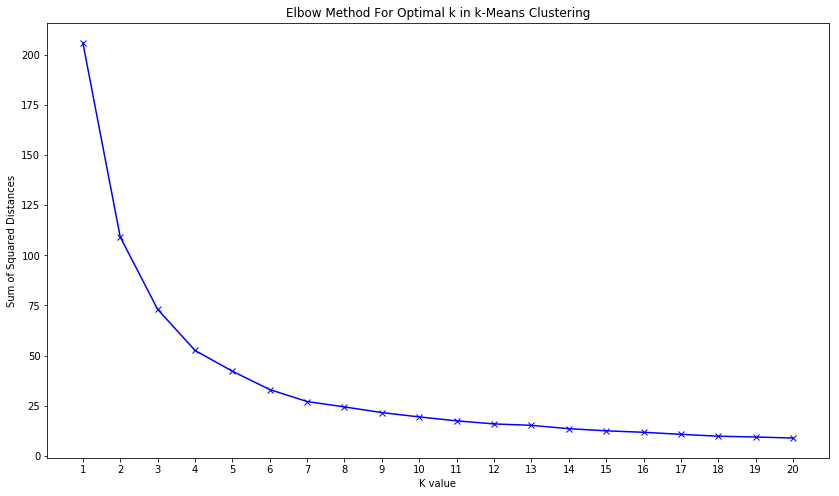

In [15]:
# Let's visualize what the optimal k should be.  Per the elbow test, the point at which 
plt.figure(figsize=(14,8))
plt.plot(Ks, sum_of_squared_distances, 'bx-')
plt.xlabel('K value')
plt.ylabel('Sum of Squared Distances')
plt.title('Elbow Method For Optimal k in k-Means Clustering')
plt.xticks(Ks)
plt.show()

In [16]:
# Initializing the model with my hypothesis set that there are 11 clusters (because there are 11 neighborhoods)
# len(toronto_df['Borough'].unique())
k_means = KMeans(n_clusters=11, init='k-means++', n_init=15, max_iter=500)

# Fitting the model to the feature set
k_means.fit(X)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=500,
    n_clusters=11, n_init=15, n_jobs=None, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [17]:
# Let's append the predicted labels to our dataset
toronto_df['y_hat'] = k_means.labels_
toronto_df.head(10)

,Postcode,Borough,Neighbourhood,Latitude,Longitude,y,y_hat
0,M3A,North York,Parkwoods,43.752440,-79.329271,0,4
1,M4A,North York,Victoria Village,43.730421,-79.313320,0,6
2,M5A,Downtown Toronto,"Harbourfront, Regent Park",43.655120,-79.362640,1,5
3,M6A,North York,"Lawrence Heights, Lawrence Manor",43.723125,-79.451589,0,3
4,M7A,Queen's Park,Queen's Park,43.661102,-79.391035,2,5
5,M9A,Etobicoke,Islington Avenue,43.662242,-79.528379,3,2
6,M1B,Scarborough,"Rouge, Malvern",43.811525,-79.195517,4,1
7,M3B,North York,Don Mills North,43.749195,-79.361905,0,4
8,M4B,East York,"Woodbine Gardens, Parkview Hill",43.707535,-79.311773,5,8
9,M5B,Downtown Toronto,"Ryerson, Garden District",43.657363,-79.378180,1,5


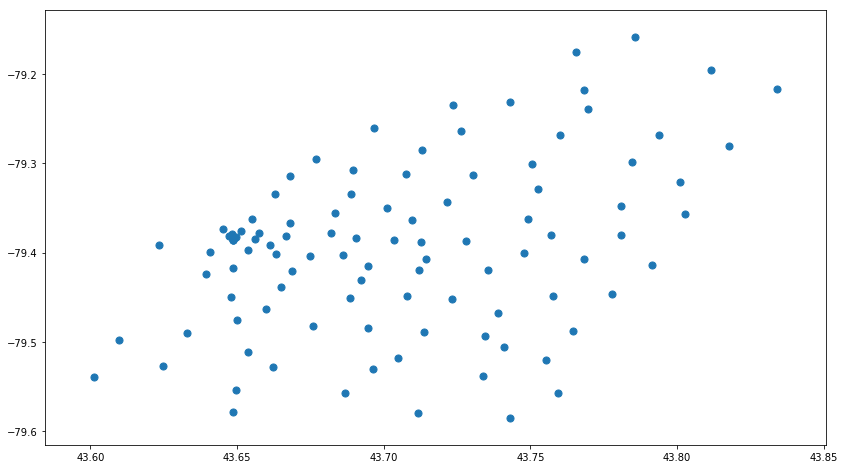

In [18]:
# Visualizing the raw lat, long combos
plt.figure(figsize=(14, 8))
plt.scatter(x=toronto_df['Latitude'], y=toronto_df['Longitude'], s=50)
plt.show()

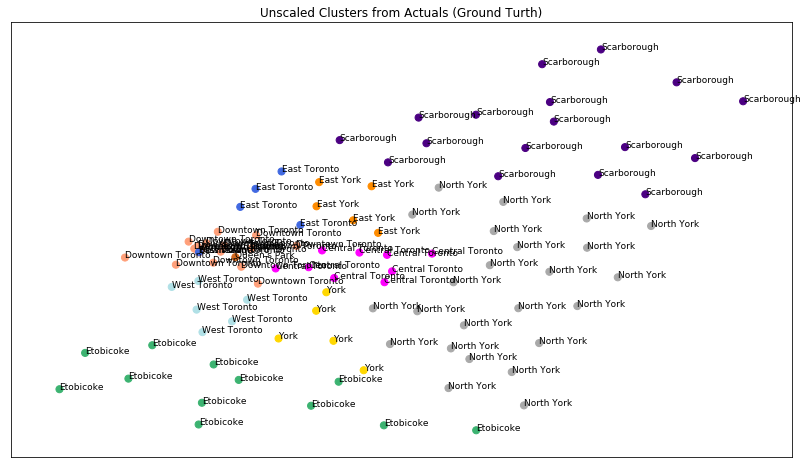

In [24]:
# Visualizing how the actual neighborhoods cluster
colors = np.array(['darkgray', 'lightsalmon', 'chocolate', 'mediumseagreen', 'indigo', 'darkorange', 'gold', 'royalblue', 'powderblue', 'magenta', 'crimson'])

fig = plt.figure(figsize=(14, 8))
ax2 = fig.add_subplot(1, 1, 1)
plt.scatter(x=toronto_df['Latitude'], y=toronto_df['Longitude'], c=colors[toronto_df['y']], s=50)
for label, x, y in zip(toronto_df['Borough'], toronto_df['Latitude'], toronto_df['Longitude']):
    plt.annotate(s=label, xy=(x, y), size=9)

ax2.set_title('Unscaled Clusters from Actuals (Ground Turth)')
ax2.set_xticks(())
ax2.set_yticks(())
plt.show()

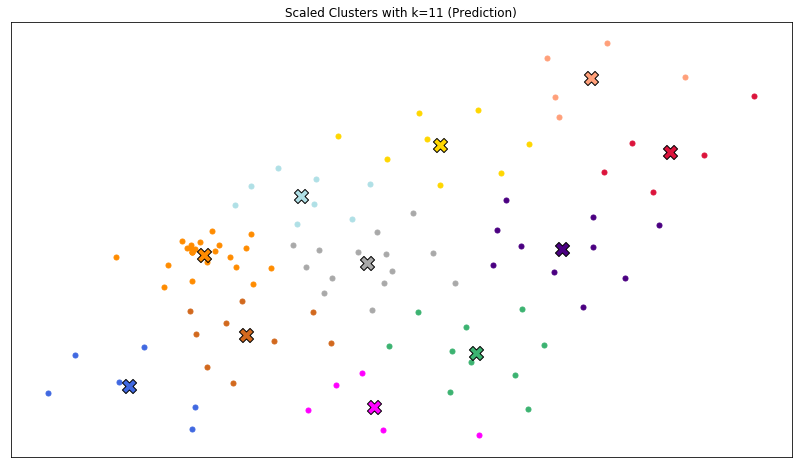

In [25]:
# Visualizing what the unsupervized clusters look like
fig = plt.figure(figsize=(14, 8))

ax = fig.add_subplot(1, 1, 1)

for k, col in zip(range(len(k_means.cluster_centers_)), colors):
    my_members = (k_means.labels_ == k)
    cluster_center = k_means.cluster_centers_[k]
    ax.scatter(X[my_members, 0], X[my_members, 1], c=colors[k], marker='.', s=100)
    ax.scatter(cluster_center[0], cluster_center[1], c=colors[k], marker='X', edgecolor='k', s=200)
    ax.set_title(f'Scaled Clusters with k={k+1} (Prediction)')

ax.set_xticks(())
ax.set_yticks(())
plt.show()

In [26]:
# We want to make sure the labels that were assigned 
for real, pred in set(zip(toronto_df['y'], toronto_df['Borough'])):
    print(real, pred)

8 West Toronto
4 Scarborough
6 York
10 Mississauga
2 Queen's Park
5 East York
0 North York
9 Central Toronto
7 East Toronto
3 Etobicoke
1 Downtown Toronto


Alright!  Looking pretty good!  We have 11 Toronto Neighborhoods, and we've properly clustered them.  Now, let's explore the city a bit using the Four Square API.  The 11 centroids can reveal some pretty interesting neighborhood trends.  Let's see what's uniquely good about each neighborhood. 🛍️

In [27]:
# Let's unscale the centroids to get their real world coordinates
k_means.cluster_centers_

array([[ 0.03211734, -0.03327627],
       [ 1.43810144,  2.11081593],
       [-0.73264269, -0.86632747],
       [ 0.71363626, -1.07501572],
       [ 1.26023963,  0.13476013],
       [-0.99406869,  0.06075011],
       [ 0.48957906,  1.33618394],
       [-1.46984317, -1.454101  ],
       [-0.38271975,  0.74271747],
       [ 0.07218183, -1.69846866],
       [ 1.93634609,  1.25995534]])

In [28]:
y_inverse = StandardScaler().fit(toronto_df[['Latitude', 'Longitude']]).inverse_transform(k_means.cluster_centers_)
y_inverse

array([[ 43.706503  , -79.39797645],
       [ 43.78019842, -79.19731065],
       [ 43.66641768, -79.47594179],
       [ 43.74222519, -79.49547294],
       [ 43.7708757 , -79.3822499 ],
       [ 43.6527149 , -79.38917651],
       [ 43.7304811 , -79.26980853],
       [ 43.62777692, -79.53095157],
       [ 43.68475908, -79.32535112],
       [ 43.708603  , -79.55382196],
       [ 43.80631419, -79.27694277]])

In [39]:
centroid_df = pd.DataFrame(y_inverse)
centroid_df.columns = ['lat', 'lng']
centroid_df['borough'] = ['Downtown Toronto', 'Scarborough', 'North York', 'East York', 'East Toronto', 'York', 'Queen\'s Park', 'Mississauga', 'Central Toronto', 'Etobicoke', 'West Toronto']
centroid_df

,lat,lng,borough
0,43.706503,-79.397976,Downtown Toronto
1,43.780198,-79.197311,Scarborough
2,43.666418,-79.475942,North York
3,43.742225,-79.495473,East York
4,43.770876,-79.382250,East Toronto
5,43.652715,-79.389177,York
6,43.730481,-79.269809,Queen's Park
7,43.627777,-79.530952,Mississauga
8,43.684759,-79.325351,Central Toronto
9,43.708603,-79.553822,Etobicoke


In [41]:
# Let's take a look at what the centroids looks like scaled for the real world
toronto_lat, toronto_long = 43.651070, -79.347015
centroid_map = folium.Map(location=[toronto_lat, toronto_long], zoom_start=10, width=800, height=500)

for lat, lng, in zip(centroid_df['lat'], centroid_df['lng']):
    folium.CircleMarker(
        location=[lat, lng],
        radius=15,
        color='blue',
        popup= f'{lat, lng}',
        fill = True,
        fill_color='blue',
        fill_opacity=0.6
    ).add_to(centroid_map)

centroid_map

## Mississauga (7) and Downtown Toronto (0) Recommended Food Spot Exploration!

In [76]:
# The code was removed by Watson Studio for sharing.

In [80]:
# Let's explore what makes a few bouroughs so special
miss_food_url = f'https://api.foursquare.com/v2/venues/explore?client_id={CLIENT_ID}&client_secret={CLIENT_SECRET}&ll={MISSISSAGUA[0]},{MISSISSAGUA[1]}&v={VERSION}&radius={RADIUS}&limit={LIMIT}&section={SELECTIONS[0]}'
down_food_url = f'https://api.foursquare.com/v2/venues/explore?client_id={CLIENT_ID}&client_secret={CLIENT_SECRET}&ll={DOWNTOWN_TORONTO[0]},{DOWNTOWN_TORONTO[1]}&v={VERSION}&radius={RADIUS}&limit={LIMIT}&section={SELECTIONS[0]}'
scar_food_url = f'https://api.foursquare.com/v2/venues/explore?client_id={CLIENT_ID}&client_secret={CLIENT_SECRET}&ll={SCARBOROUGH[0]},{SCARBOROUGH[1]}&v={VERSION}&radius={RADIUS}&limit={LIMIT}&section={SELECTIONS[0]}'

In [81]:
miss_food_results = requests.get(miss_food_url).json()
miss_food_results

{'meta': {'code': 200, 'requestId': '5d51c9ebd69ed0002def533c'},
 'response': {'headerLocation': 'Islington - City Centre West',
  'headerFullLocation': 'Islington - City Centre West, Toronto',
  'headerLocationGranularity': 'neighborhood',
  'query': 'food',
  'totalResults': 4,
  'suggestedBounds': {'ne': {'lat': 43.63227692066671,
    'lng': -79.5247463048222},
   'sw': {'lat': 43.62327691166671, 'lng': -79.53715683284437}},
  'groups': [{'type': 'Recommended Places',
    'name': 'recommended',
    'items': [{'reasons': {'count': 0,
       'items': [{'summary': 'This spot is popular',
         'type': 'general',
         'reasonName': 'globalInteractionReason'}]},
      'venue': {'id': '4ae217eaf964a520a28a21e3',
       'name': 'Royal Meats BBQ',
       'location': {'address': '710 Kipling Ave',
        'crossStreet': 'North Queen St.',
        'lat': 43.62535277307904,
        'lng': -79.52907322434908,
        'labeledLatLngs': [{'label': 'display',
          'lat': 43.62535277307

In [109]:
# These are top recommended spots in the Mississagua bourough
miss_items = miss_food_results['response']['groups'][0]['items']
miss_df = json_normalize(miss_items)
miss_df

,reasons.count,reasons.items,referralId,venue.categories,venue.id,venue.location.address,venue.location.cc,venue.location.city,venue.location.country,venue.location.crossStreet,venue.location.distance,venue.location.formattedAddress,venue.location.labeledLatLngs,venue.location.lat,venue.location.lng,venue.location.postalCode,venue.location.state,venue.name,venue.photos.count,venue.photos.groups
0,0,"[{'summary': 'This spot is popular', 'type': '...",e-3-4ae217eaf964a520a28a21e3-0,"[{'id': '4bf58dd8d48988d16c941735', 'name': 'B...",4ae217eaf964a520a28a21e3,710 Kipling Ave,CA,Toronto,Canada,North Queen St.,309,"[710 Kipling Ave (North Queen St.), Toronto ON...","[{'label': 'display', 'lat': 43.62535277307904...",43.625353,-79.529073,NaN,ON,Royal Meats BBQ,0,[]
1,0,"[{'summary': 'This spot is popular', 'type': '...",e-3-510ed6a3e4b03a117f35a442-1,"[{'id': '4bf58dd8d48988d1c1941735', 'name': 'M...",510ed6a3e4b03a117f35a442,817 Kipling Ave,CA,Toronto,Canada,Norseman St,457,"[817 Kipling Ave (Norseman St), Toronto ON M8Z...","[{'label': 'display', 'lat': 43.63188818744491...",43.631888,-79.530778,M8Z 5G8,ON,La Tortilleria,0,[]
2,0,"[{'summary': 'This spot is popular', 'type': '...",e-3-5be23e49e97dfb002c8f7e46-2,"[{'id': '4bf58dd8d48988d1cc941735', 'name': 'S...",5be23e49e97dfb002c8f7e46,NaN,CA,Toronto,Canada,NaN,309,"[Toronto ON M8Z 2G9, Canada]","[{'label': 'display', 'lat': 43.626777, 'lng':...",43.626777,-79.527362,M8Z 2G9,ON,Top Gun Steak &Burger,0,[]
3,0,"[{'summary': 'This spot is popular', 'type': '...",e-3-4fb27945e4b0d2c83d3113cd-3,"[{'id': '4bf58dd8d48988d153941735', 'name': 'B...",4fb27945e4b0d2c83d3113cd,21 Jutland Road,CA,Etobicoke,Canada,Kipling,391,"[21 Jutland Road (Kipling), Etobicoke ON, Canada]","[{'label': 'display', 'lat': 43.62665661432599...",43.626657,-79.526349,NaN,ON,Burrito Boyz,0,[]


In [114]:
# Let's clean this up a bit
miss_filtered_columns = ['venue.name', 'venue.categories'] + [col for col in miss_df.columns if col.startswith('venue.location.')] + ['venue.id']
miss_dataframe_filtered = miss_df.loc[:, miss_filtered_columns]
miss_dataframe_filtered

,venue.name,venue.categories,venue.location.address,venue.location.cc,venue.location.city,venue.location.country,venue.location.crossStreet,venue.location.distance,venue.location.formattedAddress,venue.location.labeledLatLngs,venue.location.lat,venue.location.lng,venue.location.postalCode,venue.location.state,venue.id
0,Royal Meats BBQ,"[{'id': '4bf58dd8d48988d16c941735', 'name': 'B...",710 Kipling Ave,CA,Toronto,Canada,North Queen St.,309,"[710 Kipling Ave (North Queen St.), Toronto ON...","[{'label': 'display', 'lat': 43.62535277307904...",43.625353,-79.529073,NaN,ON,4ae217eaf964a520a28a21e3
1,La Tortilleria,"[{'id': '4bf58dd8d48988d1c1941735', 'name': 'M...",817 Kipling Ave,CA,Toronto,Canada,Norseman St,457,"[817 Kipling Ave (Norseman St), Toronto ON M8Z...","[{'label': 'display', 'lat': 43.63188818744491...",43.631888,-79.530778,M8Z 5G8,ON,510ed6a3e4b03a117f35a442
2,Top Gun Steak &Burger,"[{'id': '4bf58dd8d48988d1cc941735', 'name': 'S...",NaN,CA,Toronto,Canada,NaN,309,"[Toronto ON M8Z 2G9, Canada]","[{'label': 'display', 'lat': 43.626777, 'lng':...",43.626777,-79.527362,M8Z 2G9,ON,5be23e49e97dfb002c8f7e46
3,Burrito Boyz,"[{'id': '4bf58dd8d48988d153941735', 'name': 'B...",21 Jutland Road,CA,Etobicoke,Canada,Kipling,391,"[21 Jutland Road (Kipling), Etobicoke ON, Canada]","[{'label': 'display', 'lat': 43.62665661432599...",43.626657,-79.526349,NaN,ON,4fb27945e4b0d2c83d3113cd


In [115]:
def get_category_type(row):
    '''
    function that extracts the category of the venue
    '''
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name'] # plucking out just the category name and leaving that as the only thing in the categories column

In [117]:
miss_dataframe_filtered['venue.categories'] = miss_dataframe_filtered.apply(get_category_type, axis=1)

In [118]:
miss_dataframe_filtered

,venue.name,venue.categories,venue.location.address,venue.location.cc,venue.location.city,venue.location.country,venue.location.crossStreet,venue.location.distance,venue.location.formattedAddress,venue.location.labeledLatLngs,venue.location.lat,venue.location.lng,venue.location.postalCode,venue.location.state,venue.id
0,Royal Meats BBQ,Burger Joint,710 Kipling Ave,CA,Toronto,Canada,North Queen St.,309,"[710 Kipling Ave (North Queen St.), Toronto ON...","[{'label': 'display', 'lat': 43.62535277307904...",43.625353,-79.529073,NaN,ON,4ae217eaf964a520a28a21e3
1,La Tortilleria,Mexican Restaurant,817 Kipling Ave,CA,Toronto,Canada,Norseman St,457,"[817 Kipling Ave (Norseman St), Toronto ON M8Z...","[{'label': 'display', 'lat': 43.63188818744491...",43.631888,-79.530778,M8Z 5G8,ON,510ed6a3e4b03a117f35a442
2,Top Gun Steak &Burger,Steakhouse,NaN,CA,Toronto,Canada,NaN,309,"[Toronto ON M8Z 2G9, Canada]","[{'label': 'display', 'lat': 43.626777, 'lng':...",43.626777,-79.527362,M8Z 2G9,ON,5be23e49e97dfb002c8f7e46
3,Burrito Boyz,Burrito Place,21 Jutland Road,CA,Etobicoke,Canada,Kipling,391,"[21 Jutland Road (Kipling), Etobicoke ON, Canada]","[{'label': 'display', 'lat': 43.62665661432599...",43.626657,-79.526349,NaN,ON,4fb27945e4b0d2c83d3113cd


In [119]:
miss_dataframe_filtered.columns = [col.split('.')[-1] for col in miss_dataframe_filtered.columns]
miss_dataframe_filtered.head(10)

,name,categories,address,cc,city,country,crossStreet,distance,formattedAddress,labeledLatLngs,lat,lng,postalCode,state,id
0,Royal Meats BBQ,Burger Joint,710 Kipling Ave,CA,Toronto,Canada,North Queen St.,309,"[710 Kipling Ave (North Queen St.), Toronto ON...","[{'label': 'display', 'lat': 43.62535277307904...",43.625353,-79.529073,NaN,ON,4ae217eaf964a520a28a21e3
1,La Tortilleria,Mexican Restaurant,817 Kipling Ave,CA,Toronto,Canada,Norseman St,457,"[817 Kipling Ave (Norseman St), Toronto ON M8Z...","[{'label': 'display', 'lat': 43.63188818744491...",43.631888,-79.530778,M8Z 5G8,ON,510ed6a3e4b03a117f35a442
2,Top Gun Steak &Burger,Steakhouse,NaN,CA,Toronto,Canada,NaN,309,"[Toronto ON M8Z 2G9, Canada]","[{'label': 'display', 'lat': 43.626777, 'lng':...",43.626777,-79.527362,M8Z 2G9,ON,5be23e49e97dfb002c8f7e46
3,Burrito Boyz,Burrito Place,21 Jutland Road,CA,Etobicoke,Canada,Kipling,391,"[21 Jutland Road (Kipling), Etobicoke ON, Canada]","[{'label': 'display', 'lat': 43.62665661432599...",43.626657,-79.526349,NaN,ON,4fb27945e4b0d2c83d3113cd


In [123]:
miss_food_map = folium.Map(location=(MISSISSAGUA[0], MISSISSAGUA[1]), zoom_start=12, tiles='Stamen Watercolor') # generate map centred around the Mississagua bourough centroid

# add Mississagua as a red circle mark
folium.CircleMarker(
    location=[MISSISSAGUA[0], MISSISSAGUA[1]],
    radius=10,
    popup='Mississagua',
    fill=True,
    color='red',
    fill_color='red',
    fill_opacity=0.6
    ).add_to(miss_food_map)

# add popular spots to the map as blue circle markers
for lat, lng, label, cat in zip(miss_dataframe_filtered['lat'], miss_dataframe_filtered['lng'], miss_dataframe_filtered['name'], miss_dataframe_filtered['categories']):
    folium.CircleMarker(
        location=[lat, lng],
        radius=5,
        popup=(label, cat),
        fill=True,
        color='blue',
        fill_color='blue',
        fill_opacity=0.6
        ).add_to(miss_food_map)

miss_food_map

# 🌮 🥩 🌯 🍔

#### Some of the most popular food in the Mississagua area are burger, steakhouse, burrito, and Mexican food restaurants.  There are also a lot fewer popular options in this area, so let's look into the more populous Downtown Toronto area and find their top 4 food categories.

In [124]:
down_food_results = requests.get(down_food_url).json()
down_food_results

{'meta': {'code': 200, 'requestId': '5d51dcddad178900399fe10f'},
 'response': {'suggestedFilters': {'header': 'Tap to show:',
   'filters': [{'name': 'Open now', 'key': 'openNow'}]},
  'headerLocation': 'Davisville',
  'headerFullLocation': 'Davisville, Toronto',
  'headerLocationGranularity': 'neighborhood',
  'query': 'food',
  'totalResults': 51,
  'suggestedBounds': {'ne': {'lat': 43.71100300242863,
    'lng': -79.3917630373839},
   'sw': {'lat': 43.70200299342863, 'lng': -79.40418985304458}},
  'groups': [{'type': 'Recommended Places',
    'name': 'recommended',
    'items': [{'reasons': {'count': 0,
       'items': [{'summary': 'This spot is popular',
         'type': 'general',
         'reasonName': 'globalInteractionReason'}]},
      'venue': {'id': '4ad772faf964a520a70a21e3',
       'name': 'The Keg Steakhouse & Bar',
       'location': {'address': '2201 Yonge St',
        'crossStreet': 'at Eglinton Ave',
        'lat': 43.70546405087482,
        'lng': -79.39808535059794,
 

In [125]:
# These are top recommended spots in the Downtown Toronto bourough
down_items = down_food_results['response']['groups'][0]['items']
down_df = json_normalize(down_items)
down_df

,reasons.count,reasons.items,referralId,venue.categories,venue.id,venue.location.address,venue.location.cc,venue.location.city,venue.location.country,venue.location.crossStreet,...,venue.location.formattedAddress,venue.location.labeledLatLngs,venue.location.lat,venue.location.lng,venue.location.postalCode,venue.location.state,venue.name,venue.photos.count,venue.photos.groups,venue.venuePage.id
0,0,"[{'summary': 'This spot is popular', 'type': '...",e-3-4ad772faf964a520a70a21e3-0,"[{'id': '4bf58dd8d48988d1cc941735', 'name': 'S...",4ad772faf964a520a70a21e3,2201 Yonge St,CA,Toronto,Canada,at Eglinton Ave,...,"[2201 Yonge St (at Eglinton Ave), Toronto ON M...","[{'label': 'display', 'lat': 43.70546405087482...",43.705464,-79.398085,M4S 2B2,ON,The Keg Steakhouse & Bar,0,[],NaN
1,0,"[{'summary': 'This spot is popular', 'type': '...",e-3-521e0c6c04939a8ad55d93d3-1,"[{'id': '4bf58dd8d48988d1d3941735', 'name': 'V...",521e0c6c04939a8ad55d93d3,90 Eglinton Avenue East,CA,Toronto,Canada,Yonge & Eglinton,...,"[90 Eglinton Avenue East (Yonge & Eglinton), T...","[{'label': 'display', 'lat': 43.70732441045359...",43.707324,-79.395649,M4P 1A6,ON,Fresh,0,[],NaN
2,0,"[{'summary': 'This spot is popular', 'type': '...",e-3-589f58fbd0bb3e25a8e5a88a-2,"[{'id': '4bf58dd8d48988d111941735', 'name': 'J...",589f58fbd0bb3e25a8e5a88a,2291 Yonge St,CA,Toronto,Canada,at Eglinton Ave E,...,"[2291 Yonge St (at Eglinton Ave E), Toronto ON...","[{'label': 'display', 'lat': 43.70751656277915...",43.707517,-79.398456,M4P 2C6,ON,Rolltation,0,[],NaN
3,0,"[{'summary': 'This spot is popular', 'type': '...",e-3-4ad4c061f964a520a2f720e3-3,"[{'id': '4bf58dd8d48988d110941735', 'name': 'I...",4ad4c061f964a520a2f720e3,2373 Yonge St.,CA,Toronto,Canada,NaN,...,"[2373 Yonge St., Toronto ON M4P 2C8, Canada]","[{'label': 'display', 'lat': 43.70932882869532...",43.709329,-79.398823,M4P 2C8,ON,Grazie Ristorante,0,[],NaN
4,0,"[{'summary': 'This spot is popular', 'type': '...",e-3-5977834ba2a6ce21c60fe91e-4,"[{'id': '55a59bace4b013909087cb24', 'name': 'R...",5977834ba2a6ce21c60fe91e,90 Eglinton Avenue East,CA,Toronto,Canada,NaN,...,"[90 Eglinton Avenue East, Toronto ON M4P 1A6, ...","[{'label': 'display', 'lat': 43.70730228095368...",43.707302,-79.395854,M4P 1A6,ON,Kinton Ramen,0,[],NaN
5,0,"[{'summary': 'This spot is popular', 'type': '...",e-3-4b7ef2b1f964a520980b30e3-5,"[{'id': '4bf58dd8d48988d1bd941735', 'name': 'S...",4b7ef2b1f964a520980b30e3,50 Eglinton Avenue East,CA,Toronto,Canada,at Yonge Street,...,"[50 Eglinton Avenue East (at Yonge Street), To...","[{'label': 'display', 'lat': 43.70730359911103...",43.707304,-79.396901,M4P 1A6,ON,Fit for Life,0,[],NaN
6,0,"[{'summary': 'This spot is popular', 'type': '...",e-3-58f29b66149946327a3713c6-6,"[{'id': '4bf58dd8d48988d155941735', 'name': 'G...",58f29b66149946327a3713c6,40 Eglinton Avenue East,CA,Toronto,Canada,NaN,...,"[40 Eglinton Avenue East, Toronto ON M4P 3A2, ...","[{'label': 'display', 'lat': 43.70709833066808...",43.707098,-79.397009,M4P 3A2,ON,Prohibition Gastrohouse,0,[],NaN
7,0,"[{'summary': 'This spot is popular', 'type': '...",e-3-544d3b30498e333e2fa24c53-7,"[{'id': '4bf58dd8d48988d16d941735', 'name': 'C...",544d3b30498e333e2fa24c53,174 Eglinton Avenue East,CA,Toronto,Canada,Redpath Ave.,...,"[174 Eglinton Avenue East (Redpath Ave.), Toro...","[{'label': 'display', 'lat': 43.70789076616744...",43.707891,-79.393049,NaN,ON,Istanbul Cafe & Espresso Bar,0,[],NaN
8,0,"[{'summary': 'This spot is popular', 'type': '...",e-3-53865482498edb61054992bd-8,"[{'id': '4bf58dd8d48988d14a941735', 'name': 'V...",53865482498edb61054992bd,2350 Yonge Street,CA,Toronto,Canada,NaN,...,"[2350 Yonge Street, Toronto ON M4P 2E6, Canada]","[{'label': 'display', 'lat': 43.70851901243233...",43.708519,-79.398764,M4P 2E6,ON,Star King,0,[],NaN
9,0,"[{'summary': 'This spot is popular', 'type': '...",e-3-55e648c2498e05836b7febc5-9,"[{'id': '4bf58dd8d48988d1c1941735', 'name': 'M...",55e648c2498e05836b7febc5,NaN,CA,Toronto,Canada,NaN,...,"[Toronto ON, 

In [126]:
# As we can see, there are already a lot more recommended food hot spots in Downtown Toronto.  Let's see what's available
down_filtered_columns = ['venue.name', 'venue.categories'] + [col for col in down_df.columns if col.startswith('venue.location.')] + ['venue.id']
down_dataframe_filtered = down_df.loc[:, down_filtered_columns]
down_dataframe_filtered['venue.categories'] = down_dataframe_filtered.apply(get_category_type, axis=1)
down_dataframe_filtered.columns = [col.split('.')[-1] for col in down_dataframe_filtered.columns]

down_dataframe_filtered.head(10)

,name,categories,address,cc,city,country,crossStreet,distance,formattedAddress,labeledLatLngs,lat,lng,postalCode,state,id
0,The Keg Steakhouse & Bar,Steakhouse,2201 Yonge St,CA,Toronto,Canada,at Eglinton Ave,115,"[2201 Yonge St (at Eglinton Ave), Toronto ON M...","[{'label': 'display', 'lat': 43.70546405087482...",43.705464,-79.398085,M4S 2B2,ON,4ad772faf964a520a70a21e3
1,Fresh,Vegetarian / Vegan Restaurant,90 Eglinton Avenue East,CA,Toronto,Canada,Yonge & Eglinton,208,"[90 Eglinton Avenue East (Yonge & Eglinton), T...","[{'label': 'display', 'lat': 43.70732441045359...",43.707324,-79.395649,M4P 1A6,ON,521e0c6c04939a8ad55d93d3
2,Rolltation,Japanese Restaurant,2291 Yonge St,CA,Toronto,Canada,at Eglinton Ave E,119,"[2291 Yonge St (at Eglinton Ave E), Toronto ON...","[{'label': 'display', 'lat': 43.70751656277915...",43.707517,-79.398456,M4P 2C6,ON,589f58fbd0bb3e25a8e5a88a
3,Grazie Ristorante,Italian Restaurant,2373 Yonge St.,CA,Toronto,Canada,NaN,321,"[2373 Yonge St., Toronto ON M4P 2C8, Canada]","[{'label': 'display', 'lat': 43.70932882869532...",43.709329,-79.398823,M4P 2C8,ON,4ad4c061f964a520a2f720e3
4,Kinton Ramen,Ramen Restaurant,90 Eglinton Avenue East,CA,Toronto,Canada,NaN,192,"[90 Eglinton Avenue East, Toronto ON M4P 1A6, ...","[{'label': 'display', 'lat': 43.70730228095368...",43.707302,-79.395854,M4P 1A6,ON,5977834ba2a6ce21c60fe91e
5,Fit for Life,Salad Place,50 Eglinton Avenue East,CA,Toronto,Canada,at Yonge Street,124,"[50 Eglinton Avenue East (at Yonge Street), To...","[{'label': 'display', 'lat': 43.70730359911103...",43.707304,-79.396901,M4P 1A6,ON,4b7ef2b1f964a520980b30e3
6,Prohibition Gastrohouse,Gastropub,40 Eglinton Avenue East,CA,Toronto,Canada,NaN,102,"[40 Eglinton Avenue East, Toronto ON M4P 3A2, ...","[{'label': 'display', 'lat': 43.70709833066808...",43.707098,-79.397009,M4P 3A2,ON,58f29b66149946327a3713c6
7,Istanbul Cafe & Espresso Bar,Café,174 Eglinton Avenue East,CA,Toronto,Canada,Redpath Ave.,425,"[174 Eglinton Avenue East (Redpath Ave.), Toro...","[{'label': 'display', 'lat': 43.70789076616744...",43.707891,-79.393049,NaN,ON,544d3b30498e333e2fa24c53
8,Star King,Vietnamese Restaurant,2350 Yonge Street,CA,Toronto,Canada,NaN,233,"[2350 Yonge Street, Toronto ON M4P 2E6, Canada]","[{'label': 'display', 'lat': 43.70851901243233...",43.708519,-79.398764,M4P 2E6,ON,53865482498edb61054992bd
9,Chipotle Mexican Grill,Mexican Restaurant,NaN,CA,Toronto,Canada,NaN,185,"[Toronto ON, Canada]","[{'label': 'display', 'lat': 43.70815173828545...",43.708152,-79.398278,NaN,ON,55e648c2498e05836b7febc5


In [134]:
# Now let's see how many of each kind of food spot we have in Downtown Toronto
down_dataframe_filtered['categories'].value_counts()

Restaurant                       3
Italian Restaurant               3
Fast Food Restaurant             3
Japanese Restaurant              1
Vegetarian / Vegan Restaurant    1
Steakhouse                       1
Ramen Restaurant                 1
Gastropub                        1
Mexican Restaurant               1
Taco Place                       1
Sushi Restaurant                 1
Buffet                           1
Caribbean Restaurant             1
French Restaurant                1
Bakery                           1
Middle Eastern Restaurant        1
Pizza Place                      1
Café                             1
Breakfast Spot                   1
Burger Joint                     1
Deli / Bodega                    1
Indian Restaurant                1
Vietnamese Restaurant            1
Salad Place                      1
Name: categories, dtype: int64

In [135]:
down_food_map = folium.Map(location=(DOWNTOWN_TORONTO[0], DOWNTOWN_TORONTO[1]), zoom_start=12, tiles='Stamen Watercolor') # generate map centred around the Downtown Toronto bourough centroid

# add Downtown Toronto as a red circle mark
folium.CircleMarker(
    location=[DOWNTOWN_TORONTO[0], DOWNTOWN_TORONTO[1]],
    radius=10,
    popup='Downtown Toronto',
    fill=True,
    color='red',
    fill_color='red',
    fill_opacity=0.6
    ).add_to(down_food_map)

# add popular spots to the map as blue circle markers
for lat, lng, label, cat in zip(down_dataframe_filtered['lat'], down_dataframe_filtered['lng'], down_dataframe_filtered['name'], down_dataframe_filtered['categories']):
    folium.CircleMarker(
        location=[lat, lng],
        radius=5,
        popup=(label, cat),
        fill=True,
        color='blue',
        fill_color='blue',
        fill_opacity=0.6
        ).add_to(down_food_map)

down_food_map

# 🍝 🍟 🍣 🥗🍕

#### Some of the most popular food in the Downtown Toronto area are Italian and fast food restaurants (the rest of the categories only show up once).  While I do question some people's choice since a lot of fast food joints were ranked as popular and 'recommended'.  But to each their own!  One thing that is pretty definitive is that if you want more variety of cuisine, Downtown Toronto has a lot more recommended options that Mississagua (more diversity), but if you're craving a excellent burrito, you may want to take the trip out to Mississagua (more homogeneity).

##### I hope you enjoyed this exploration of Toronto Neighborhood suburbs and their food profile triends!